In [1]:
import os
os.chdir("../../")

import pandas as pd
import numpy as np
from datetime import datetime

import re
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize

# Gensim/Spacy
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel 
import spacy

from src.text.utils import *
from src.text.lda import *

In [2]:
target = os.getcwd() + "/data/text/solomon_islands/"
news_path = [filename for filename in os.listdir(target)  if "news" in filename]

In [3]:
news = pd.DataFrame()
for path in news_path:
    temp = pd.read_csv(target + path).drop("Unnamed: 0", axis=1)
    temp["from"] = path.replace("_news.csv", "")
    if news.empty:
        news = temp
    else: 
        news = pd.concat([news, temp], axis=0)

news = news[news.news.isna() != True].reset_index(drop=True)

In [20]:
news[(news.date >= "2017-01-01") & (news.date <="2017-06-01")].groupby("from").count()

,url,title,date,news,tag,busecon_alt
from,,,,,,
sibc,265,265,265,265,265,265
solomon_times,55,0,55,55,55,55


In [5]:
def convert_datetime_format(date_str):
    try:
        date_obj = datetime.strptime(date_str, '%Y-%m-%d')
        # Convert it to the desired format
        return date_obj.strftime('%Y-%m-%d')
    except ValueError:
        return None

## LDA (mallet)

In [7]:
en = spacy.load('en_core_web_sm')
spacy_stopwords = list(en.Defaults.stop_words)

In [8]:
nltk_stopwords = stopwords.words("english")
nltk_unique = [sw for sw in nltk_stopwords if sw not in spacy_stopwords]
spacy_stopwords.extend(nltk_unique)

In [9]:
data = news.news.values.tolist()
data_words = list(sent_to_words(data))

In [10]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram = gensim.models.Phrases(bigram[data_words], min_count=5, threshold=100)
trigram_mod = gensim.models.phrases.Phraser(trigram)

texts_preprocessed = preprocess_text(data_words, spacy_stopwords, bigram_mod,
                                     trigram_mod, nlp)

Stopwords has been done.


In [11]:
id2word = corpora.Dictionary(texts_preprocessed)
texts = texts_preprocessed
corpus = [id2word.doc2bow(text) for text in texts]

In [12]:
from gensim.models.wrappers import LdaMallet
mallet_path = os.getcwd() + '/../mallet-2.0.8/bin/mallet'
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=texts_preprocessed,
                                                        mallet_path=mallet_path,
                                                        start=2,
                                                        limit=20,
                                                        step=1)

Mallet LDA: 2 topics, 1 topic bits, 1 topic mask
Data loaded.
max tokens: 2592
total tokens: 4283306
<10> LL/token: -8.39296
<20> LL/token: -8.1986
<30> LL/token: -7.99391
<40> LL/token: -7.92899

0	25	government country support work people development project island community include year provide national woman service leader provincial program important issue 
1	25	police people year public officer time report week case yesterday day team covid court follow member student issue receive add 

<50> LL/token: -7.9008
<60> LL/token: -7.88495
<70> LL/token: -7.87589
<80> LL/token: -7.87124
<90> LL/token: -7.86623

0	25	government country work support people development project community island include year provide national woman service leader provincial important program ensure 
1	25	police people public year officer time report week case yesterday team day member covid issue follow court medium add receive 

<100> LL/token: -7.86325
<110> LL/token: -7.861
<120> LL/token: -7.85797
<130> 

<970> LL/token: -7.84383
<980> LL/token: -7.84412
<990> LL/token: -7.84403

0	25	government country work support community people development project island year include provide woman service national student leader school important program 
1	25	police people public year officer report time member week case issue yesterday day follow court medium covid provincial add team 

<1000> LL/token: -7.84458

Total time: 1 minutes 49 seconds
Mallet LDA: 3 topics, 2 topic bits, 11 topic mask
Data loaded.
max tokens: 2592
total tokens: 4283306
<10> LL/token: -8.77164
<20> LL/token: -8.42655
<30> LL/token: -8.15359
<40> LL/token: -8.06343

0	16.66667	community work people support year country woman island student team school program visit local good provide training project health area 
1	16.66667	government country development provincial issue national member leader people project support include parliament add policy land province service business ensure 
2	16.66667	police officer public case p

<660> LL/token: -7.94079
<670> LL/token: -7.94036
<680> LL/token: -7.9401
<690> LL/token: -7.94021

0	16.66667	people community work year woman student team school health island good local time visit child program training country area water 
1	16.66667	government country development project support national provincial leader issue include member provide work ensure service business people fund parliament policy 
2	16.66667	police public officer report case covid yesterday year court people medium election follow man time company week call issue member 

<700> LL/token: -7.94047
<710> LL/token: -7.93984
<720> LL/token: -7.94038
<730> LL/token: -7.93954
<740> LL/token: -7.9401

0	16.66667	people community work year woman student team school health island good local time visit child country training program water area 
1	16.66667	government country development project support provincial national leader issue include member provide work ensure service business fund parliament policy land 

<310> LL/token: -7.98905
<320> LL/token: -7.98915
<330> LL/token: -7.98857
<340> LL/token: -7.98826

0	12.5	government country support development project national provide provincial include work business fund service policy plan ensure issue economic address improve 
1	12.5	people community covid health area province water service week report continue local market western island medical country operation time number 
2	12.5	people year woman work student school country leader good team community visit training time today program event child education hold 
3	12.5	police public officer issue member court report year parliament election case medium man yesterday company law charge provincial order rsipf 

<350> LL/token: -7.98814
<360> LL/token: -7.987
<370> LL/token: -7.98665
<380> LL/token: -7.98683
<390> LL/token: -7.98639

0	12.5	government country support development project provide national provincial include work fund business policy service plan ensure economic issue address imp


0	12.5	government country support development project national provide provincial include work fund business policy service plan ensure issue economic address improve 
1	12.5	people community covid health area province water service report week continue country market local western island medical travel road operation 
2	12.5	people year woman work student school leader community good team country visit training time child today program event day education 
3	12.5	police public officer issue member court report parliament election year case medium yesterday man company law charge order rsipf provincial 

<900> LL/token: -7.98993
<910> LL/token: -7.99018
<920> LL/token: -7.99062
<930> LL/token: -7.9895
<940> LL/token: -7.99024

0	12.5	government country support development project national provide include provincial work fund policy business service ensure plan issue economic address improve 
1	12.5	people community covid health area province water service week report continue island m

<360> LL/token: -8.04131
<370> LL/token: -8.04205
<380> LL/token: -8.04068
<390> LL/token: -8.04105

0	10	police officer public court report year case company man law charge rsipf accuse order matter money pay medium land yesterday 
1	10	year work people woman community student school country visit support training child program event good education family young day island 
2	10	country development project government support provide include policy fund business economic island improve work plan ensure service sector market develop 
3	10	people covid health service water community province week area country continue medical travel report number road affect island team work 
4	10	government provincial member issue national people leader parliament election province official statement add decision process team state group meeting hold 

<400> LL/token: -8.04119
<410> LL/token: -8.04223
<420> LL/token: -8.04187
<430> LL/token: -8.04218
<440> LL/token: -8.04187

0	10	police public officer r

<860> LL/token: -8.02432
<870> LL/token: -8.02397
<880> LL/token: -8.02374
<890> LL/token: -8.02289

0	10	police public officer year court report case company man charge law rsipf accuse yesterday matter money pay land order force 
1	10	year woman student work school community people team training visit good child country event program time education day young today 
2	10	country support development project government provide work include business service economic policy fund island improve plan ensure develop sector management 
3	10	people covid health community service water area province week country work medical report travel island continue affect number road month 
4	10	government provincial member issue people leader national parliament election province statement add state process decision official meeting office yesterday group 

<900> LL/token: -8.0228
<910> LL/token: -8.02297
<920> LL/token: -8.02242
<930> LL/token: -8.02233
<940> LL/token: -8.0227

0	10	police public office

<290> LL/token: -8.07696

0	8.33333	team country covid health year people day time event week good today medical start island play number place hospital month 
1	8.33333	government provincial member issue parliament election statement national people leader public process decision state medium add meeting constituency executive office 
2	8.33333	work community support woman student school program people country training year visit education child opportunity provide important leader australian youth 
3	8.33333	project country government development support service provide increase include economic policy fund plan improve sector year ensure business system management 
4	8.33333	people company area land water province operation work local community road market business add affect western travel issue supply island 
5	8.33333	police officer case public court year report man charge rsipf accuse yesterday force order high person matter allege incident time 

<300> LL/token: -8.0767
<310> L

<660> LL/token: -8.06945
<670> LL/token: -8.069
<680> LL/token: -8.06892
<690> LL/token: -8.06797

0	8.33333	country team covid health day time week year people good medical service number today month play start place follow yesterday 
1	8.33333	government provincial issue member parliament election statement people national leader public process decision state add province meeting medium constituency office 
2	8.33333	work community woman people student school support year program training visit child country education event opportunity important leader youth young 
3	8.33333	government country project development support provide service include policy economic fund ensure plan improve increase sector management national develop region 
4	8.33333	people company area land water local market province business community operation work island road food add affect supply site log 
5	8.33333	police officer public court case year report man charge rsipf accuse yesterday force order matter hi

<50> LL/token: -8.2192
<60> LL/token: -8.18423
<70> LL/token: -8.16404
<80> LL/token: -8.15096
<90> LL/token: -8.14

0	7.14286	government issue provincial parliament land member company statement public decision process add pay medium office state executive concern question claim 
1	7.14286	people team election year member time today good leader day event hold visit country constituency lead official play yesterday group 
2	7.14286	government country development support project policy include economic national provide sector ensure island develop region plan work address important partner 
3	7.14286	people province covid health country week service continue community western case medical number provincial travel situation day response work receive 
4	7.14286	water area service increase island year business high local road food cost expect percent market supply source site include disaster 
5	7.14286	police officer court man public case year charge rsipf accuse report force yesterday al

<400> LL/token: -8.09368
<410> LL/token: -8.09384
<420> LL/token: -8.09305
<430> LL/token: -8.09274
<440> LL/token: -8.09333

0	7.14286	government issue provincial member parliament land statement decision public process state add pay medium executive leader people office concern call 
1	7.14286	team year people election member time visit country today day good leader event hold constituency official lead yesterday island play 
2	7.14286	government country development project support policy include economic provide national sector ensure island region develop plan fund work assistance improve 
3	7.14286	people covid country health province service week western continue case medical community travel number include response situation provincial ensure provide 
4	7.14286	business area water local company year market island increase food road percent cost high site expect log source small industry 
5	7.14286	police officer court man public case year charge rsipf accuse report force yesterd

<750> LL/token: -8.09475
<760> LL/token: -8.09521
<770> LL/token: -8.09502
<780> LL/token: -8.09502
<790> LL/token: -8.095

0	7.14286	government issue provincial member parliament statement land public decision process state leader people add office executive concern pay call question 
1	7.14286	year team election people visit time member country today day good event hold constituency leader official lead yesterday week island 
2	7.14286	government country development project support policy include economic provide national fund sector ensure island develop region plan improve assistance work 
3	7.14286	people service covid health country province week western continue case medical include travel provide response number community situation receive ensure 
4	7.14286	business company area water local year market island increase food road high people cost percent log site industry small source 
5	7.14286	police officer court man public case year charge rsipf accuse report yesterday force 

<100> LL/token: -8.15811
<110> LL/token: -8.15347
<120> LL/token: -8.14998
<130> LL/token: -8.14826
<140> LL/token: -8.14653

0	6.25	development project support government country provide policy economic improve sector develop fund business include plan resource increase system infrastructure management 
1	6.25	team year time good event local day play market start place today week open host game yesterday hold tourism island 
2	6.25	government country people leader member issue national meeting security island visit official medium state support nation meet continue important address 
3	6.25	police officer court election man case public year charge accuse yesterday allege incident arrest victim report matter investigation law vehicle 
4	6.25	covid health service country rsipf week case continue operation public medical province include number people response provide ensure worker report 
5	6.25	government provincial issue company parliament land public member process pay decision state

<430> LL/token: -8.12937
<440> LL/token: -8.13085

0	6.25	development project government support provide country policy economic fund improve business sector plan develop include service resource system infrastructure management 
1	6.25	year team time event good day today play start week place local host hold visit yesterday island open game end 
2	6.25	government country people leader member issue national meeting island security state medium official visit support nation meet continue important address 
3	6.25	police officer court election man public case year charge rsipf accuse yesterday allege incident arrest victim report matter investigation vehicle 
4	6.25	covid health service country people case week province medical continue include number public provide response operation worker report situation western 
5	6.25	government provincial issue parliament company land public member process pay decision statement executive office claim question report add province premier 
6	6.25	p


0	6.25	development project government support provide economic policy country business fund sector include improve develop plan service system infrastructure resource management 
1	6.25	year team time event day good today play start place hold yesterday visit week host game late island open group 
2	6.25	government country people leader member issue national island meeting security state medium visit official support nation continue meet address important 
3	6.25	police officer court man election public case charge rsipf year accuse yesterday allege incident report arrest victim investigation matter vehicle 
4	6.25	covid health service country people province week case medical number include continue response public provide worker situation operation travel western 
5	6.25	government provincial issue parliament company land public member process pay statement decision executive office claim province question report add premier 
6	6.25	people area water market local island road food co

<10> LL/token: -9.76064
<20> LL/token: -9.03005
<30> LL/token: -8.53497
<40> LL/token: -8.35743

0	5.55556	team water island people area time local market good food play place game road live start home village site big 
1	5.55556	people woman country leader election member support community visit work event island hold important day national today nation constituency official 
2	5.55556	project development support country government economic provide sector improve fund include develop policy infrastructure increase rural resource plan region management 
3	5.55556	covid health country people service province medical include community continue case week response travel risk hospital provide disaster western number 
4	5.55556	government provincial issue parliament land member process decision province national meeting company executive minister current premier log statement bill policy 
5	5.55556	public people issue medium add report state country call year business time concern good pay 

<300> LL/token: -8.12877
<310> LL/token: -8.12935
<320> LL/token: -8.12929
<330> LL/token: -8.12972
<340> LL/token: -8.12955

0	5.55556	team water island local market time good food area play game place year start site people live small competition big 
1	5.55556	woman country people election leader visit event island support member today day official year hold nation church important open include 
2	5.55556	project development support country economic provide sector improve develop include fund business infrastructure resource increase rural area policy access region 
3	5.55556	covid health service country people medical case include week provide response continue number province travel disaster hospital risk community border 
4	5.55556	government provincial province member national parliament land meeting process executive budget current minister policy premier office issue bill meet party 
5	5.55556	people issue report public add medium call state country concern statement action la

<600> LL/token: -8.12437
<610> LL/token: -8.12547
<620> LL/token: -8.12575
<630> LL/token: -8.12595
<640> LL/token: -8.12627

0	5.55556	team water island local market time food good area play year game place start site big small product live competition 
1	5.55556	woman people country election visit leader event today island day support member year official hold constituency nation church include candidate 
2	5.55556	project development country support economic provide sector improve develop include business infrastructure resource fund increase rural area region policy service 
3	5.55556	covid health service country people medical case include week provide response travel continue number province disaster hospital risk ensure border 
4	5.55556	government provincial member national province parliament land meeting process executive budget current policy minister office meet premier bill issue year 
5	5.55556	people issue public report add medium call state country concern statement dec

<900> LL/token: -8.12875
<910> LL/token: -8.12864
<920> LL/token: -8.129
<930> LL/token: -8.12994
<940> LL/token: -8.13003

0	5.55556	team water island local market time food good area play year game place start site product small big competition find 
1	5.55556	woman people country election visit leader event today day island support member year official hold nation church open candidate vote 
2	5.55556	project development country support economic provide sector develop include improve infrastructure resource increase business area region fund rural service key 
3	5.55556	covid health service country people medical case include provide week continue response travel number disaster hospital risk province border community 
4	5.55556	government provincial member national province parliament meeting land process executive current budget minister policy office year meet premier bill plan 
5	5.55556	people issue report public add medium state call country statement concern decision action q

<200> LL/token: -8.16829
<210> LL/token: -8.16766
<220> LL/token: -8.16745
<230> LL/token: -8.16741
<240> LL/token: -8.16551

0	5	team year event time good today day country play hold host start game place week open island yesterday end culture 
1	5	community woman work people training program child support family youth young leader important opportunity encourage activity learn church role member 
2	5	people water area island food live community village report affect home time find family problem boat call supply life small 
3	5	country development policy government economic support sector island develop region include resource regional partner ensure key provide address system security 
4	5	police officer court man case charge public rsipf accuse year allege incident arrest victim matter force investigation vehicle yesterday report 
5	5	covid country health case public week number travel response continue confirm situation report include operation follow service ensure border day 
6	

<480> LL/token: -8.14769
<490> LL/token: -8.14772

0	5	team year time event good today day country play host start hold game place week open island yesterday culture late 
1	5	community woman work people training program child support family youth young important encourage opportunity learn church activity role good train 
2	5	people water area island food report live community village affect disaster find home time problem call boat family small life 
3	5	country development policy support economic sector region develop island resource provide include government regional ensure partner key management system economy 
4	5	police officer court man case charge rsipf public accuse year allege incident arrest victim matter force investigation yesterday vehicle prosecution 
5	5	covid health country service case medical week include travel public response number hospital continue confirm border operation follow situation ensure 
6	5	business company land market pay money local year issue log 

<750> LL/token: -8.14921
<760> LL/token: -8.14857
<770> LL/token: -8.14796
<780> LL/token: -8.14811
<790> LL/token: -8.14826

0	5	team year event time good today day play country host start game hold place island week open culture late yesterday 
1	5	community woman work people training child program support family young youth important opportunity encourage learn church good activity speak role 
2	5	people area water island community food report live affect village disaster find home problem call boat time family supply small 
3	5	country development policy support economic sector develop region island include resource provide regional partner ensure key management system level economy 
4	5	police officer court man case charge rsipf public accuse year allege incident arrest victim force investigation yesterday matter vehicle prosecution 
5	5	covid health country service case medical week response include number travel public hospital confirm continue border people situation team provi

Data loaded.
max tokens: 2592
total tokens: 4283306
<10> LL/token: -9.92656
<20> LL/token: -9.15512
<30> LL/token: -8.61194
<40> LL/token: -8.41569

0	4.54545	police officer court case man charge accuse public allege incident arrest victim matter investigation year report vehicle prosecution law rsipf 
1	4.54545	service year increase country business high food percent improve system report provide rural cost economy sector level industry population financial 
2	4.54545	people visit time force add year rsipf family leave member medium work church live today issue ramsi call boat continue 
3	4.54545	country development support island region include security economic provide develop regional partner assistance government policy meeting international ensure plan partnership 
4	4.54545	student school year week receive pay officer issue education staff public medium office study teacher form add number report confirm 
5	4.54545	government provincial issue province land national public policy

<250> LL/token: -8.16311
<260> LL/token: -8.16236
<270> LL/token: -8.16121
<280> LL/token: -8.16192
<290> LL/token: -8.16119

0	4.54545	police officer court man case charge rsipf accuse public allege incident arrest victim matter investigation report vehicle force prosecution order 
1	4.54545	business increase country market year food local percent high economy service industry economic sector cost financial product growth rural good 
2	4.54545	people visit family year country time live good day today life continue island speak church home add leave late ramsi 
3	4.54545	country development support island region include security government regional assistance develop partner economic project provide policy meeting plan ensure national 
4	4.54545	year student school week receive pay education month work study payment money teacher number staff form complete yesterday accord give 
5	4.54545	government provincial issue province national land public policy budget ministry process add premi

<500> LL/token: -8.15467
<510> LL/token: -8.1548
<520> LL/token: -8.15534
<530> LL/token: -8.15357
<540> LL/token: -8.15253

0	4.54545	police officer court man case charge rsipf accuse public allege incident arrest victim force investigation matter report vehicle year prosecution 
1	4.54545	business increase market country year local food percent economy high sector economic industry product cost tourism growth grow service financial 
2	4.54545	people family year country visit time live good day life speak today leader add member continue church home nation thing 
3	4.54545	country development support island assistance region include security regional develop partner provide economic meeting agreement commitment cooperation key partnership strategy 
4	4.54545	year student school week receive pay education month money study work number payment teacher yesterday staff confirm form complete give 
5	4.54545	government provincial province national issue land policy development ministry publ

<750> LL/token: -8.15004
<760> LL/token: -8.14946
<770> LL/token: -8.15108
<780> LL/token: -8.1504
<790> LL/token: -8.15044

0	4.54545	police officer court man case charge rsipf accuse public allege incident arrest victim force investigation matter vehicle report prosecution order 
1	4.54545	business increase market country year local food percent economic economy tourism sector high industry product cost growth investment benefit grow 
2	4.54545	people family year country time good visit leader live life member day speak today add church continue work thing nation 
3	4.54545	country support development island region assistance include security regional develop partner visit economic provide meeting agreement cooperation meet work commitment 
4	4.54545	year student school week receive pay education month money work study payment teacher yesterday number complete form staff give confirm 
5	4.54545	government provincial province national issue land policy development ministry budget fund

<1000> LL/token: -8.14779

Total time: 1 minutes 56 seconds
Mallet LDA: 12 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 2592
total tokens: 4283306
<10> LL/token: -9.99101
<20> LL/token: -9.16661
<30> LL/token: -8.63216
<40> LL/token: -8.42393

0	4.16667	people woman leader member issue medium group youth political leadership change young party government role country good decision speak hold 
1	4.16667	country island visit people event year tourism host international ramsi today mission nation culture local open official world islander great 
2	4.16667	police officer covid report rsipf force case incident community public operation investigation vehicle continue suspect medium information death arrest person 
3	4.16667	work support service health community program training provide team medical include facility australian train assistance staff skill deliver centre week 
4	4.16667	government national country policy ensure plan system provincial meeting include ministry

<220> LL/token: -8.17233
<230> LL/token: -8.171
<240> LL/token: -8.16965

0	4.16667	people woman leader issue country member medium group youth political leadership good add change community call church respect law work 
1	4.16667	country island visit event people year tourism today local day official host open ceremony opportunity ramsi mission international culture great 
2	4.16667	police officer covid rsipf public operation case force report continue people vehicle travel border medium security information number station test 
3	4.16667	support community work service health program provide training medical include team assistance hospital worker train australian staff skill conduct people 
4	4.16667	government provincial province national meeting current issue policy minister executive member meet premier plan western bill state add process statement 
5	4.16667	country development support economic develop sector region resource partner opportunity key regional policy island include 

<450> LL/token: -8.16323
<460> LL/token: -8.1627
<470> LL/token: -8.16202
<480> LL/token: -8.15995
<490> LL/token: -8.16021

0	4.16667	people woman leader member issue medium country group youth political leadership add call good law respect church peace change party 
1	4.16667	country island visit event people year tourism today official local opportunity ceremony international open ramsi mission day world culture host 
2	4.16667	covid officer rsipf case operation people police public continue force travel report week security situation border number honiara ship response 
3	4.16667	community support work program service provide health training medical include team assistance hospital worker australian train staff conduct skill assist 
4	4.16667	government provincial province national member parliament meeting current minister issue executive policy premier statement meet bill office state add guadalcanal 
5	4.16667	country development support economic develop sector region policy res

<700> LL/token: -8.15481
<710> LL/token: -8.15433
<720> LL/token: -8.15508
<730> LL/token: -8.15395
<740> LL/token: -8.15462

0	4.16667	people woman leader issue medium country member group youth political add leadership good call address church law respect peace concern 
1	4.16667	country island visit event people year today tourism official local ceremony world opportunity ramsi mission open culture host great day 
2	4.16667	covid country case operation people travel public continue week situation report number health border response ship confirm boat test follow 
3	4.16667	community support work service program provide training health medical include assistance officer hospital team australian worker train conduct staff important 
4	4.16667	government provincial member province national parliament meeting minister executive current premier statement office bill issue opposition meet state add guadalcanal 
5	4.16667	country development support develop economic policy region sector re

<950> LL/token: -8.15667
<960> LL/token: -8.15643
<970> LL/token: -8.15687
<980> LL/token: -8.15734
<990> LL/token: -8.15713

0	4.16667	people woman leader issue medium country group youth add political member call good leadership address church law concern respect change 
1	4.16667	country visit island event people tourism year today official local ceremony great world opportunity ramsi day mission culture host open 
2	4.16667	covid country case people travel operation week continue public situation health report number border confirm ship follow risk boat test 
3	4.16667	community support work program service provide training health medical include assistance officer hospital team conduct australian worker train staff people 
4	4.16667	government provincial member province national parliament meeting minister executive current statement premier office bill opposition western guadalcanal policy state meet 
5	4.16667	country development support develop policy economic region sector res

<150> LL/token: -8.19958
<160> LL/token: -8.19606
<170> LL/token: -8.19248
<180> LL/token: -8.18945
<190> LL/token: -8.1872

0	3.84615	people community country event child youth visit year young support day island life program live work church world speak share 
1	3.84615	country development policy economic region island resource sector support develop regional key economy partner investment include ensure strengthen global challenge 
2	3.84615	parliament election process member constituency office act bill candidate vote general legal party register day order public follow yesterday accord 
3	3.84615	government provincial province national meeting member official meet executive issue leader western visit hold minister premier guadalcanal plan yesterday discuss 
4	3.84615	covid health country case medical people service hospital border risk test vaccine emergency week care response measure number travel day 
5	3.84615	company land operation area people report log vehicle ship boat road

<350> LL/token: -8.16916
<360> LL/token: -8.16891
<370> LL/token: -8.16821
<380> LL/token: -8.168
<390> LL/token: -8.16805

0	3.84615	people community country child year event family youth young life day live island work church leader visit speak world support 
1	3.84615	country development policy economic island region sector resource support develop regional partner economy key tourism investment strengthen include ensure global 
2	3.84615	parliament election member process office bill act constituency candidate vote general party day legal register pass order yesterday follow confirm 
3	3.84615	government provincial province national meeting member official visit meet issue executive leader western minister premier hold guadalcanal plan support delegation 
4	3.84615	covid health country case medical people service hospital border risk week emergency test vaccine number care measure include flight response 
5	3.84615	company land area people report log operation island ship boat road

<550> LL/token: -8.16664
<560> LL/token: -8.16697
<570> LL/token: -8.16556
<580> LL/token: -8.16465
<590> LL/token: -8.16586

0	3.84615	people community country child year family event youth young day life live work visit leader church speak island today world 
1	3.84615	country development economic policy island region sector develop support resource regional tourism economy partner key investment strengthen include ensure level 
2	3.84615	member parliament election process office bill act constituency candidate general vote yesterday party register day legal pass order confirm follow 
3	3.84615	government provincial province national meeting issue official visit meet member executive leader western minister premier guadalcanal plan hold discuss delegation 
4	3.84615	covid health country case medical people service hospital border risk week emergency test vaccine travel number include measure care response 
5	3.84615	company land area people island log water report ship boat operation

<750> LL/token: -8.16458
<760> LL/token: -8.16432
<770> LL/token: -8.16419
<780> LL/token: -8.16342
<790> LL/token: -8.1636

0	3.84615	people community country child year family youth young event work life day live leader church speak island visit today world 
1	3.84615	country development economic policy island region sector develop regional resource support tourism partner economy key investment strengthen include ensure challenge 
2	3.84615	member parliament election process office bill act candidate general constituency vote yesterday party day register pass follow chief order legal 
3	3.84615	government provincial province national meeting visit issue official meet leader western executive minister premier guadalcanal hold member plan delegation discuss 
4	3.84615	covid health country case medical people service hospital week risk travel emergency test vaccine include measure number care flight clinic 
5	3.84615	company land area water people island log report ship boat village op

<950> LL/token: -8.16823
<960> LL/token: -8.16841
<970> LL/token: -8.16839
<980> LL/token: -8.16803
<990> LL/token: -8.16677

0	3.84615	people country child year community family event young youth life work live day leader church speak visit island world today 
1	3.84615	country development economic island policy region sector develop regional resource support tourism economy key partner include ensure investment strengthen global 
2	3.84615	member parliament election process office act bill general candidate constituency vote party yesterday day register pass chief follow order motion 
3	3.84615	government provincial province national meeting issue visit official meet leader western minister executive premier guadalcanal member sign plan hold policy 
4	3.84615	covid health country case medical service people hospital week emergency test travel vaccine risk include care response measure number flight 
5	3.84615	company land area water people island log ship boat village report local la

<150> LL/token: -8.20523
<160> LL/token: -8.20272
<170> LL/token: -8.20053
<180> LL/token: -8.1991
<190> LL/token: -8.19784

0	3.57143	woman support development work policy include provide programme partner partnership regional program plan develop management stakeholder strengthen ensure key important 
1	3.57143	police officer court man case charge rsipf accuse allege incident year arrest victim investigation matter public prosecution suspect force yesterday 
2	3.57143	student school child year training education service staff work program study hospital teacher week provide train medical learn skill centre 
3	3.57143	country economic increase business island year sector tourism economy percent region investment industry growth high trade global international impact develop 
4	3.57143	government issue leader country meeting state statement meet decision official address add group member interest minister hold concern raise discuss 
5	3.57143	team time good play start year game week pl

<350> LL/token: -8.17897
<360> LL/token: -8.17916
<370> LL/token: -8.17689
<380> LL/token: -8.1769
<390> LL/token: -8.17787

0	3.57143	woman development support policy work include develop partner partnership provide programme ensure strengthen plan management stakeholder regional key community important 
1	3.57143	police officer court man case charge rsipf accuse allege incident year arrest victim investigation public prosecution matter suspect force allegedly 
2	3.57143	student school year child training work education program staff week study teacher learn train skill form start provide parent add 
3	3.57143	country business increase economic year sector island tourism economy percent investment high industry growth trade international region local agriculture benefit 
4	3.57143	government issue country leader meeting state meet official security address minister decision interest statement sign member hold agreement group cooperation 
5	3.57143	team time good play start game year p

<550> LL/token: -8.17724
<560> LL/token: -8.17603
<570> LL/token: -8.17531
<580> LL/token: -8.17528
<590> LL/token: -8.17433

0	3.57143	woman support development policy work partner include develop provide partnership community plan ensure management strengthen programme stakeholder key address strategy 
1	3.57143	police officer court man case charge rsipf accuse year allege incident arrest victim investigation public prosecution matter force suspect allegedly 
2	3.57143	student school year child training work program education staff week study learn teacher train skill form australian provide high start 
3	3.57143	country business increase economic year sector tourism economy percent investment industry high growth island benefit cost provide service financial international 
4	3.57143	government country issue leader meeting visit security official meet state island address minister interest sign cooperation agreement member hold discuss 
5	3.57143	team time good play start year game p

<750> LL/token: -8.17825
<760> LL/token: -8.17834
<770> LL/token: -8.17932
<780> LL/token: -8.17991
<790> LL/token: -8.17942

0	3.57143	woman support development policy work community develop partner provide partnership include ensure plan management address programme stakeholder key national strategy 
1	3.57143	police officer court man case charge rsipf accuse year allege incident arrest victim investigation public prosecution matter force suspect appeal 
2	3.57143	student school year training child work program education staff week study learn teacher train australian skill form provide officer start 
3	3.57143	country business increase economic year sector tourism percent economy service investment industry high growth financial cost provide island benefit system 
4	3.57143	country government leader visit issue meeting island official security meet state include assistance sign address cooperation region agreement minister member 
5	3.57143	team time good play start game year place 

<950> LL/token: -8.18328
<960> LL/token: -8.1834
<970> LL/token: -8.18219
<980> LL/token: -8.18315
<990> LL/token: -8.18377

0	3.57143	woman development support policy work partner develop include provide plan ensure address management programme key stakeholder strategy national community partnership 
1	3.57143	police officer court man case charge rsipf accuse allege year incident arrest victim investigation public prosecution matter force suspect appeal 
2	3.57143	student school year training child work program education staff week study learn teacher train skill form provide officer start add 
3	3.57143	country business increase economic year service sector tourism percent economy investment industry high growth financial cost provide benefit island opportunity 
4	3.57143	country government visit island leader meeting security official meet issue assistance state include region sign support cooperation regional continue ramsi 
5	3.57143	team time good play start year game place week 

<150> LL/token: -8.22053
<160> LL/token: -8.21864
<170> LL/token: -8.2168
<180> LL/token: -8.21529
<190> LL/token: -8.21157

0	3.33333	development country support economic region develop policy island sector regional partner include resource key provide partnership opportunity strengthen ensure strategy 
1	3.33333	company business land year government tourism increase log cost percent industry high financial economy export investment landowner benefit service mining 
2	3.33333	travel visit people island time family leave home day late return arrive week ship boat yesterday passenger flight service morning 
3	3.33333	woman community people youth work young event family support church day ceremony attend program opportunity peace leader speak life share 
4	3.33333	year student school education child work study week teacher staff high add form learn receive start parent award offer program 
5	3.33333	government provincial province national parliament meeting executive budget minister memb

<350> LL/token: -8.19518
<360> LL/token: -8.19426
<370> LL/token: -8.19464
<380> LL/token: -8.19266
<390> LL/token: -8.1915

0	3.33333	country development support island region develop economic partner policy sector regional include key resource partnership provide strengthen opportunity strategy global 
1	3.33333	business company land year increase tourism log percent cost industry government economy high financial export investment landowner country benefit mining 
2	3.33333	island people travel home time leave family report arrive late return ship day boat week passenger village yesterday visit flight 
3	3.33333	woman people community youth child family young work event day church support life peace program attend ceremony leader culture violence 
4	3.33333	student year school education work staff study program teacher week training child high learn form add job offer receive parent 
5	3.33333	government provincial province national meeting budget minister policy executive premier b

<550> LL/token: -8.18316
<560> LL/token: -8.18308
<570> LL/token: -8.18334
<580> LL/token: -8.18186
<590> LL/token: -8.18157

0	3.33333	country development support island region develop economic sector regional partner policy include key partnership strengthen provide opportunity resource challenge strategy 
1	3.33333	business company land year increase tourism percent log cost economy high financial government investment landowner industry country benefit mining service 
2	3.33333	people travel island home leave time report arrive ship week return boat late village day yesterday passenger family morning flight 
3	3.33333	woman people community child family youth young work event support day church life live culture attend peace violence ceremony today 
4	3.33333	student school year training education work program staff study week teacher train learn skill worker form high job opportunity add 
5	3.33333	government provincial province national meeting budget policy minister executive pr

<750> LL/token: -8.18127
<760> LL/token: -8.18117
<770> LL/token: -8.18151
<780> LL/token: -8.18086
<790> LL/token: -8.18104

0	3.33333	country development support island region develop economic regional partner partnership sector policy include key opportunity strengthen provide challenge strategy global 
1	3.33333	business company land year increase tourism percent log cost economy financial investment country high local landowner industry economic benefit mining 
2	3.33333	people travel island home report leave disaster time arrive ship week boat village return passenger affect late yesterday family flight 
3	3.33333	woman people community child family youth young event work day church life support culture live year today violence attend peace 
4	3.33333	student school year training work education program staff study week teacher train learn skill worker high form opportunity job parent 
5	3.33333	government provincial province national meeting policy budget executive minister premi

<950> LL/token: -8.17818
<960> LL/token: -8.17899
<970> LL/token: -8.1787
<980> LL/token: -8.17957
<990> LL/token: -8.17961

0	3.33333	country development support region island develop economic regional partner include policy key sector partnership strengthen opportunity challenge strategy provide global 
1	3.33333	business company land year increase tourism percent log cost economy country financial high investment local landowner industry benefit economic mining 
2	3.33333	people travel island home disaster leave report time week ship boat return arrive passenger late day yesterday flight affect village 
3	3.33333	woman people community child family youth young event day work church life live culture year support violence peace speak today 
4	3.33333	student school year training work education program staff study week teacher train learn skill worker opportunity high job form parent 
5	3.33333	government provincial province national meeting policy budget executive minister premier bi

<150> LL/token: -8.21409
<160> LL/token: -8.21285
<170> LL/token: -8.21102
<180> LL/token: -8.20727
<190> LL/token: -8.20566

0	3.125	police officer medium public rsipf operation force law information report continue security commissioner order conduct involve act station investigation unit 
1	3.125	country policy development region develop address include level resource regional strategy key global stakeholder plan system sustainable ensure management national 
2	3.125	country visit island official nation people support government assistance cooperation ramsi mission sign leader meet continue ceremony delegation acknowledge include 
3	3.125	court case charge accuse man year allege police arrest victim matter public high prosecution suspect allegedly face incident yesterday trial 
4	3.125	business increase market local country percent year tourism food economy industry economic product high growth sector agriculture good small fishery 
5	3.125	people water area road province disaster i

<350> LL/token: -8.2007
<360> LL/token: -8.20168
<370> LL/token: -8.20134
<380> LL/token: -8.2022
<390> LL/token: -8.20138

0	3.125	police officer medium public rsipf report operation force information law continue commissioner security investigation station conduct order involve act unit 
1	3.125	development country policy develop region include address resource key plan management level system ensure strategy stakeholder regional sustainable economic global 
2	3.125	country visit island official leader support nation government meet cooperation assistance ramsi mission sign people security state ceremony delegation continue 
3	3.125	court case charge accuse year man allege arrest victim matter public police high prosecution suspect face allegedly yesterday hear trial 
4	3.125	business increase market country local year tourism food percent economy industry economic product growth high sector agriculture fishery grow small 
5	3.125	water people area road island disaster vehicle provin

<550> LL/token: -8.20094
<560> LL/token: -8.20068
<570> LL/token: -8.20086
<580> LL/token: -8.20165
<590> LL/token: -8.20126

0	3.125	police officer medium public rsipf report operation force information law continue investigation suspect commissioner station involve incident security conduct arrest 
1	3.125	development country policy develop include resource region address plan key management ensure system strategy level stakeholder economic sustainable provide national 
2	3.125	country visit island official support leader government meet nation cooperation assistance security state sign meeting mission ramsi continue include agreement 
3	3.125	court case charge accuse year man allege public victim high matter prosecution face yesterday allegedly order hear trial arrest evidence 
4	3.125	business market increase country local year tourism percent food economy industry economic product growth high sector investment agriculture grow small 
5	3.125	water people area road island vehicle d

<750> LL/token: -8.20325
<760> LL/token: -8.20468
<770> LL/token: -8.20339
<780> LL/token: -8.20392
<790> LL/token: -8.20341

0	3.125	police officer medium rsipf public report force operation information law continue investigation suspect commissioner incident station involve security community act 
1	3.125	development policy country develop plan resource ensure management region include system address key level provide strategy national sustainable stakeholder economic 
2	3.125	country visit island official leader support government meeting meet nation cooperation assistance sign security state include mission agreement delegation continue 
3	3.125	court case charge accuse year man allege victim high public matter prosecution yesterday face allegedly order hear trial arrest money 
4	3.125	business market increase country year local tourism economy percent food economic industry growth product sector high investment agriculture fishery grow 
5	3.125	water people area road island disast

<950> LL/token: -8.20768
<960> LL/token: -8.20921
<970> LL/token: -8.20844
<980> LL/token: -8.208
<990> LL/token: -8.20907

0	3.125	police officer medium rsipf report public force operation information law continue investigation vehicle suspect commissioner incident station involve arrest security 
1	3.125	development policy country develop resource management include plan ensure address key system region provide level national strategy economic stakeholder sustainable 
2	3.125	country visit island official leader meeting support meet security nation government cooperation state assistance sign mission include agreement continue region 
3	3.125	court case charge accuse year man allege victim public high matter prosecution yesterday face allegedly order hear trial evidence represent 
4	3.125	business increase market country year local tourism percent economy food economic industry investment product high growth sector agriculture fishery grow 
5	3.125	people water area road island disas

<100> LL/token: -8.24188
<110> LL/token: -8.2336
<120> LL/token: -8.22608
<130> LL/token: -8.22058
<140> LL/token: -8.2171

0	2.94118	government land policy issue process budget national ministry system address bill add propose development current consultation review important ensure plan 
1	2.94118	development project economic sector support improve rural develop access key economy country growth provide strategy fund implement sustainable programme policy 
2	2.94118	election member day constituency week yesterday officer today general parliament chief people year candidate vote late number official process confirm 
3	2.94118	covid health country case medical people hospital border service test vaccine risk care clinic patient emergency measure number nurse week 
4	2.94118	student school training year education program staff study teacher learn train week skill work form high parent knowledge add opportunity 
5	2.94118	woman people community child family young youth work life church l

<250> LL/token: -8.19625
<260> LL/token: -8.19497
<270> LL/token: -8.19441
<280> LL/token: -8.19573
<290> LL/token: -8.19419

0	2.94118	government land issue policy process budget ministry system national address bill development propose plan add consultation review current ensure change 
1	2.94118	development economic sector country support develop improve rural key economy policy access project provide growth opportunity strategy achieve focus challenge 
2	2.94118	member election parliament constituency day yesterday week general today officer year candidate vote number late confirm chief process official return 
3	2.94118	covid health country case medical hospital service people test vaccine risk border emergency clinic care measure patient number nurse week 
4	2.94118	student school training year education program study staff teacher learn train week skill work high form parent knowledge start participant 
5	2.94118	woman people community child family young youth work life church l

<400> LL/token: -8.19122
<410> LL/token: -8.18993
<420> LL/token: -8.18868
<430> LL/token: -8.1894
<440> LL/token: -8.18977

0	2.94118	government land issue process policy budget system ministry bill address national propose plan current ensure add consultation review important development 
1	2.94118	development economic support sector country develop rural improve key policy provide economy opportunity growth strategy challenge partner access achieve focus 
2	2.94118	member election parliament constituency day week yesterday general today year candidate vote late number confirm chief process officer return national 
3	2.94118	covid health country case medical hospital service people risk test vaccine care border clinic patient number week emergency measure nurse 
4	2.94118	student school training year education program staff study teacher learn week train skill work form high parent knowledge start participant 
5	2.94118	woman people community child family young youth work live life d

<550> LL/token: -8.18905
<560> LL/token: -8.1895
<570> LL/token: -8.18958
<580> LL/token: -8.18839
<590> LL/token: -8.18909

0	2.94118	government land issue process policy budget ministry system bill address propose current national plan consultation review add ensure development important 
1	2.94118	development support economic country sector develop rural improve key policy provide economy challenge partner opportunity growth strategy ensure focus achieve 
2	2.94118	member election parliament constituency day yesterday week general today candidate vote number late year confirm process chief national follow register 
3	2.94118	covid health country case medical hospital service people test vaccine risk border care measure clinic emergency patient number nurse week 
4	2.94118	student school training year education program staff study teacher learn train week work skill form high knowledge participant parent opportunity 
5	2.94118	woman people child family community young youth work life

<700> LL/token: -8.19068
<710> LL/token: -8.19062
<720> LL/token: -8.19128
<730> LL/token: -8.19074
<740> LL/token: -8.19117

0	2.94118	government land issue process policy budget system ministry bill propose address national consultation review current ensure add plan important change 
1	2.94118	development support economic sector country develop improve key provide rural policy partner economy growth opportunity strategy challenge impact focus ensure 
2	2.94118	member election parliament constituency day week yesterday general today candidate vote year late number chief process confirm follow national return 
3	2.94118	covid health country case medical hospital service test vaccine risk people care number emergency clinic patient week measure nurse include 
4	2.94118	student school training year education program work study staff teacher week learn train skill form high knowledge participant programme parent 
5	2.94118	woman people community child family young youth work life live ch

<850> LL/token: -8.19157
<860> LL/token: -8.19256
<870> LL/token: -8.19195
<880> LL/token: -8.1911
<890> LL/token: -8.19196

0	2.94118	government land process policy issue budget ministry system bill propose address national consultation current review ensure important plan include add 
1	2.94118	development support economic sector country develop provide key improve policy partner rural ensure growth opportunity challenge economy strategy focus achieve 
2	2.94118	member election parliament constituency day yesterday week general today year candidate vote late number confirm chief process follow register result 
3	2.94118	covid health country case medical hospital service test vaccine people risk emergency care number clinic week patient measure nurse positive 
4	2.94118	student school training year program education staff study work week teacher learn train skill form high knowledge participant parent start 
5	2.94118	woman people community child family young youth work life live chur

<1000> LL/token: -8.19245

Total time: 2 minutes 9 seconds
Mallet LDA: 18 topics, 5 topic bits, 11111 topic mask
Data loaded.
max tokens: 2592
total tokens: 4283306
<10> LL/token: -10.31407
<20> LL/token: -9.29357
<30> LL/token: -8.70101
<40> LL/token: -8.48765

0	2.77778	support community project work provide program training service assistance australian improve facility include deliver ramsi train build skill mission assist 
1	2.77778	police officer public rsipf force law report medium operation vehicle order commissioner act investigation information involve station security appeal continue 
2	2.77778	student school year education week study teacher form staff start parent registration number child receive high add scholarship learn complete 
3	2.77778	water medical people travel supply service hospital health ship boat passenger home clinic care family live vessel nurse child affect 
4	2.77778	land company area people log report local operation landowner site mining fishery island

<150> LL/token: -8.24236
<160> LL/token: -8.23878
<170> LL/token: -8.23722
<180> LL/token: -8.23466
<190> LL/token: -8.23367

0	2.77778	project support provide training program work service development improve assistance community australian rural include fund facility access deliver management infrastructure 
1	2.77778	police officer rsipf force public operation vehicle investigation medium law report incident continue commissioner suspect security station arrest involve information 
2	2.77778	student school year education week staff study teacher form learn high parent start add work receive award child scholarship complete 
3	2.77778	water people medical supply disaster village travel ship boat home hospital live affect area family clinic vessel nurse damage time 
4	2.77778	company land area log site operation local resource landowner activity fishery mining survey people director fish fishing export chief operate 
5	2.77778	member election parliament constituency yesterday general 

<300> LL/token: -8.21851
<310> LL/token: -8.21747
<320> LL/token: -8.2166
<330> LL/token: -8.2151
<340> LL/token: -8.21572

0	2.77778	project support provide development service work improve program rural fund assistance australian community infrastructure access include facility deliver build area 
1	2.77778	police officer rsipf force public vehicle operation investigation incident continue suspect law commissioner medium ramsi security station report arrest involve 
2	2.77778	student school training year education staff study week teacher train learn program skill form work parent high start add knowledge 
3	2.77778	water people supply disaster village home travel ship boat area family affect live medical clinic vessel island nurse damage leave 
4	2.77778	company land area log operation site resource local fishery landowner activity mining director fish fishing operate survey process export chief 
5	2.77778	member election constituency parliament yesterday general candidate vote day 

<450> LL/token: -8.20909
<460> LL/token: -8.20767
<470> LL/token: -8.20735
<480> LL/token: -8.20694
<490> LL/token: -8.20669

0	2.77778	project support development provide work service improve fund assistance infrastructure rural program australian build access community include deliver facility area 
1	2.77778	police officer rsipf force vehicle operation public investigation incident continue suspect commissioner ramsi law medium station security arrest report involve 
2	2.77778	student school training year education staff study program week teacher train learn work skill form parent high start knowledge scholarship 
3	2.77778	water people disaster village travel area home island ship boat affect supply live family vessel damage nurse leave time sea 
4	2.77778	company land log area operation site resource landowner local fishery activity mining director issue operate sign process fishing chief export 
5	2.77778	member election constituency parliament general yesterday candidate day vo

<600> LL/token: -8.20585
<610> LL/token: -8.20493
<620> LL/token: -8.2054
<630> LL/token: -8.2048
<640> LL/token: -8.2052

0	2.77778	project support development provide work service improve fund infrastructure assistance rural build australian program building access facility include deliver community 
1	2.77778	police officer rsipf force public vehicle operation investigation incident suspect continue ramsi commissioner security station arrest law medium report involve 
2	2.77778	student school training year education staff program study teacher learn train week skill work form parent knowledge high start add 
3	2.77778	people water travel island disaster village area home ship boat affect live supply damage report vessel leave time family sea 
4	2.77778	company land log operation area resource site issue landowner fishery local activity mining director sign operate process owner agreement carry 
5	2.77778	member election parliament constituency yesterday general day candidate today v

<750> LL/token: -8.20825
<760> LL/token: -8.20711
<770> LL/token: -8.20748
<780> LL/token: -8.2072
<790> LL/token: -8.20719

0	2.77778	project support development provide work service improve fund infrastructure rural assistance build australian program building access community facility include deliver 
1	2.77778	police officer rsipf force vehicle operation investigation public incident suspect continue commissioner ramsi security arrest medium station report law involve 
2	2.77778	student school training year education program study staff teacher learn week train work skill form parent knowledge high start add 
3	2.77778	water people island travel disaster area village home ship boat affect live supply damage vessel leave passenger report sea time 
4	2.77778	company land log operation area issue site resource landowner fishery activity local director mining operate sign business owner process agreement 
5	2.77778	member election parliament constituency general yesterday candidate vot

<900> LL/token: -8.20708
<910> LL/token: -8.20736
<920> LL/token: -8.20702
<930> LL/token: -8.207
<940> LL/token: -8.20737

0	2.77778	project support development work provide service fund improve infrastructure rural build assistance australian program building access facility deliver include community 
1	2.77778	police officer rsipf force vehicle operation public investigation incident suspect continue ramsi commissioner security station arrest medium report law involve 
2	2.77778	student school training year education program study staff teacher work learn train week skill form parent high knowledge start scholarship 
3	2.77778	water people travel island disaster road area village ship boat home affect live damage vessel supply time passenger sea leave 
4	2.77778	company land log operation area issue site landowner resource fishery sign operate activity mining local director business owner agreement process 
5	2.77778	member election parliament constituency yesterday general candidat

<50> LL/token: -8.39711
<60> LL/token: -8.33495
<70> LL/token: -8.2972
<80> LL/token: -8.27493
<90> LL/token: -8.25877

0	2.63158	team time good play game start yesterday today final competition place player match lead week half goal early tomorrow point 
1	2.63158	company land food local log area product export fishery landowner mining operation resource industry market farmer agriculture price activity high 
2	2.63158	student school training year education program week study learn teacher train skill staff form high participant work knowledge start programme 
3	2.63158	government provincial province national people western budget executive premier guadalcanal year add plan development current continue issue policy address meeting 
4	2.63158	country island visit leader meeting region issue meet state regional world year nation mission discuss delegation ramsi level global include 
5	2.63158	covid country case health risk number test vaccine percent measure record increase total week f

<200> LL/token: -8.20924
<210> LL/token: -8.20584
<220> LL/token: -8.20509
<230> LL/token: -8.20328
<240> LL/token: -8.20399

0	2.63158	team play time good game start final competition player match place today yesterday goal week lead sport half stage year 
1	2.63158	company land food local log area market product fishery export landowner industry operation mining farmer resource price produce agriculture activity 
2	2.63158	student school training year education program study week teacher learn train staff skill work form participant knowledge high start complete 
3	2.63158	government provincial province national people year western budget executive premier guadalcanal plan add development current continue week ministry assure policy 
4	2.63158	country leader meeting visit meet issue region island regional member include state hold discuss mission world official delegation level year 
5	2.63158	covid country case health number risk test vaccine week measure record increase total borde

<350> LL/token: -8.19698
<360> LL/token: -8.19648
<370> LL/token: -8.19442
<380> LL/token: -8.19357
<390> LL/token: -8.19336

0	2.63158	team play good time game start competition final player match today week place yesterday goal half lead sport year stage 
1	2.63158	land company market local log food area product export fishery landowner industry sell mining farmer resource operation price produce activity 
2	2.63158	student school training year education program study teacher week train learn skill staff work form participant knowledge high start complete 
3	2.63158	government provincial province national year people western budget executive premier guadalcanal plan add development current continue week ministry yesterday work 
4	2.63158	country meeting leader issue region meet regional island include member hold state discuss mission year delegation level international ramsi world 
5	2.63158	covid country case number percent test vaccine risk increase health record border measure to

<500> LL/token: -8.19114
<510> LL/token: -8.19197
<520> LL/token: -8.19193
<530> LL/token: -8.1916
<540> LL/token: -8.19179

0	2.63158	team time play good game start final competition player match place week yesterday goal sport half today lead year win 
1	2.63158	land company market local food log area product export fishery sell landowner industry mining farmer resource operation price produce activity 
2	2.63158	student school training year education program study week teacher train learn skill staff participant form work knowledge high parent start 
3	2.63158	government provincial province national year western budget people executive premier guadalcanal plan add development ministry current week continue yesterday work 
4	2.63158	country meeting leader region meet issue regional island include member hold discuss state mission year international delegation level discussion ramsi 
5	2.63158	covid country case number percent increase risk test vaccine border record measure total hea

<650> LL/token: -8.19387
<660> LL/token: -8.19509
<670> LL/token: -8.19427
<680> LL/token: -8.19514
<690> LL/token: -8.19576

0	2.63158	team good play time game start competition final player match place goal today sport week yesterday half lead win host 
1	2.63158	land company market local log food area product export industry sell landowner fishery mining operation farmer activity price produce resource 
2	2.63158	student school training year education program study teacher week train staff learn skill work form high parent knowledge complete start 
3	2.63158	government provincial province national year western budget people executive premier guadalcanal plan add current development continue ministry week yesterday statement 
4	2.63158	country leader meeting region issue meet regional island member include hold state discuss international year level address global conference world 
5	2.63158	covid country case number increase border test vaccine risk percent record measure week trave

<800> LL/token: -8.19559
<810> LL/token: -8.1953
<820> LL/token: -8.19669
<830> LL/token: -8.19618
<840> LL/token: -8.19665

0	2.63158	team good play time game start competition final player match lead goal place today sport half yesterday week year host 
1	2.63158	land company market local food log area product export industry sell landowner fishery operation mining farmer resource activity price produce 
2	2.63158	student school training year education program study teacher week train staff skill learn work form high parent knowledge scholarship start 
3	2.63158	government provincial province national year western budget people executive guadalcanal premier plan add current development continue ministry policy statement term 
4	2.63158	country leader meeting region issue meet island regional include member hold state discuss international level address world year global action 
5	2.63158	covid country case number border test vaccine increase risk continue week record total measure pe

<950> LL/token: -8.20106
<960> LL/token: -8.20049
<970> LL/token: -8.20171
<980> LL/token: -8.20204
<990> LL/token: -8.20237

0	2.63158	team good play time game competition player final match start place yesterday goal sport lead today half week win point 
1	2.63158	land company market local log food area product industry export sell landowner fishery mining operation activity farmer resource price produce 
2	2.63158	student school training year education program study teacher train week staff learn skill work form high parent knowledge scholarship start 
3	2.63158	government provincial province national year people western budget executive premier guadalcanal plan add current continue development ministry week yesterday fund 
4	2.63158	country leader meeting region issue island meet regional include member hold state discuss international address action level global world year 
5	2.63158	covid country case number worker border test vaccine week travel record increase measure continue 

In [13]:
best_model = model_list[np.argmax(coherence_values)]
best_model.print_topics()

[(0,
  '0.069*"project" + 0.055*"support" + 0.033*"development" + 0.029*"work" + 0.026*"provide" + 0.024*"service" + 0.019*"improve" + 0.018*"fund" + 0.018*"infrastructure" + 0.017*"rural"'),
 (1,
  '0.115*"police" + 0.061*"officer" + 0.027*"rsipf" + 0.020*"force" + 0.016*"vehicle" + 0.015*"operation" + 0.015*"investigation" + 0.015*"public" + 0.014*"incident" + 0.013*"suspect"'),
 (2,
  '0.057*"student" + 0.052*"school" + 0.037*"training" + 0.031*"year" + 0.027*"education" + 0.018*"program" + 0.016*"study" + 0.015*"staff" + 0.015*"teacher" + 0.014*"learn"'),
 (3,
  '0.032*"water" + 0.030*"people" + 0.014*"travel" + 0.014*"island" + 0.014*"disaster" + 0.013*"area" + 0.012*"village" + 0.011*"ship" + 0.011*"boat" + 0.011*"home"'),
 (4,
  '0.041*"company" + 0.038*"land" + 0.016*"log" + 0.015*"operation" + 0.014*"issue" + 0.014*"area" + 0.011*"site" + 0.011*"landowner" + 0.010*"resource" + 0.010*"sign"'),
 (5,
  '0.068*"member" + 0.038*"election" + 0.019*"parliament" + 0.017*"constituency"

In [14]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

mallet_lda_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(best_model)
vis_data = gensimvis.prepare(mallet_lda_model, corpus, id2word)
ldaviz_path = os.getcwd() + "/data/text/solomon_islands/st_ldavis.html"
pyLDAvis.save_html(vis_data, ldaviz_path)
pyLDAvis.display(vis_data)

/Users/czhang/miniforge3/envs/po/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/czhang/miniforge3/envs/po/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/czhang/miniforge3/envs/po/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


## HDP/CTM

In [15]:
from gensim.models import CoherenceModel, HdpModel
hdpmodel = HdpModel(corpus=corpus, id2word=id2word)

In [158]:
from sklearn.feature_extraction.text import CountVectorizer
import scipy
from corextopic import corextopic as ct
vectorizer = CountVectorizer(
    stop_words=spacy_stopwords,
    ngram_range=(1,3),
    binary=True
)

In [167]:
word_doc = vectorizer.fit_transform(news["news"])
word_doc = scipy.sparse.csr_matrix(word_doc)

In [143]:
keywords = [["economics", "development", "economy"], ["tourism", "visit"],
            ["community"], ["government", "politics", "election"],
            ["food", "price", "security", "inflation"], ["police"],
            ["labor", "job", "employment", "work"]]

In [165]:
# Get words that label the columns (needed to extract readable topics and make anchoring easier)
words = vectorizer.vocabulary_.keys()

In [168]:
corrtopics_model = ct.Corex(n_hidden=len(keywords))
corrtopics_model.fit(word_doc, anchors=keywords, words=words)

## LDA filter/Category Keyword

In [16]:
dominant_topics = []
for idx, val in enumerate(best_model.load_document_topics()):
    sort_topic_lst = sorted(val, key=lambda x:x[1], reverse=True)
    topic_1, topic_2 = sort_topic_lst[0][0], sort_topic_lst[1][0]
    dominant_topics.append({"first": topic_1, "second": topic_2})

In [26]:
dominant_topics_df = pd.DataFrame(dominant_topics)
news_with_dominant_topics = pd.concat([news, dominant_topics_df], axis=1)

busecon_topic_num = [17]
busecon_news = (news_with_dominant_topics[
    (news_with_dominant_topics["first"].isin(busecon_topic_num)) |
    (news_with_dominant_topics["second"].isin(busecon_topic_num))].reset_index(
        drop=True))

In [94]:
# ss_df = pd.DataFrame()
# for news in text_lst[:-1]:
#     news_lst = news.split("All rights reserved.")
#     header = news_lst[0]
#     header_lst = header.split("\n")
#     topic = header_lst[0]
#     sample = news_lst[-1].replace("\n", " ").strip()
    
#     sid = SentimentIntensityAnalyzer()
#     ss = sid.polarity_scores(sample)
#     ss_temp = pd.DataFrame(ss, columns=ss.keys(), index=[0])
#     date_pattern = r'\b\d{1,2} (?:January|February|March|April|May|June|July|August|September|October|November|December) \d{4}\b'
#     ss_temp["date"] = re.findall(date_pattern, c[0])[0]
#     ss_temp["text"] = sample
#     ss_df = pd.concat([ss_df, ss_temp], axis=0)

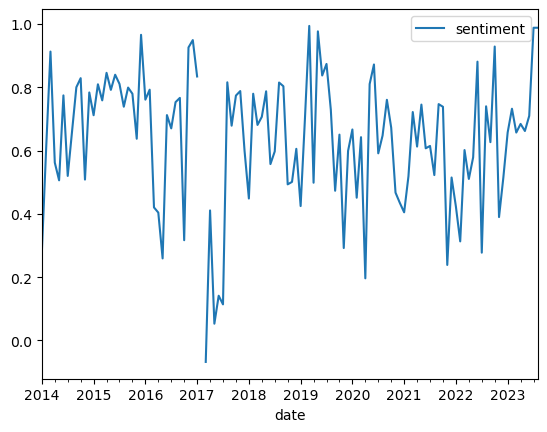

In [28]:
busecon_sent = busecon_news.set_index("date").groupby(pd.Grouper(freq="M"))[["sentiment"]].mean().reset_index()
busecon_sent.plot(x="date", y="sentiment");

In [21]:
work_df = news[news.news.str.contains("employment") == True]

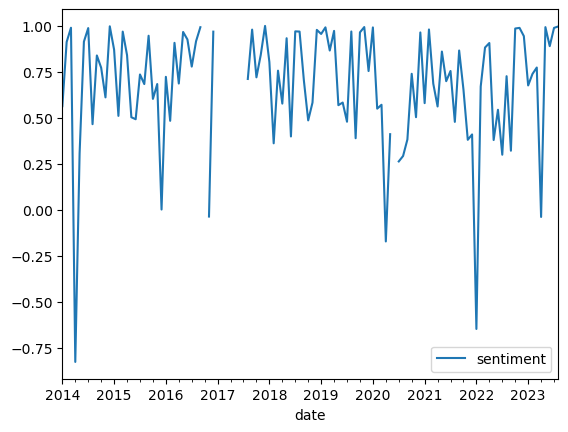

In [22]:
work_sent = work_df.set_index("date").groupby(pd.Grouper(freq="M"))[["sentiment"]].mean().reset_index()
work_sent.plot(x="date", y="sentiment");

In [5]:
busecon_alt = ["business", "development", "economy", "economic", "banks"]

news["tag"] = news["tag"].str.lower()


def check_category(row, terms):
    return any([word in str(row) for word in terms])


news["busecon_alt"] = news["news"].apply(check_category, terms=busecon_alt)
busecon_alt_df = news[news["busecon_alt"] == True].reset_index(drop=True)

In [6]:
busecon_alt_df = busecon_alt_df.set_index("date").groupby(pd.Grouper(freq="M"))[["sentiment"]].mean().reset_index()
busecon_alt_df.plot(x="date", y="sentiment");

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'